# Jores et al 2021 Plotting 
**Authorship:**
Adam Klie (last updated: *06/08/2023*)
***
**Description:**
Notebook to generate plots for the Jores et al (2021) dataset that are not included in the other notebooks.
 - Summary table of benchmarking results for for each model type
 - Cleaner seq track plots for top sequences
 - TomTom filter annotation analysis
 - Loss and metric plots
***

In [138]:
# General imports
import os
import sys
import numpy as np
import pandas as pd
from copy import deepcopy
from itertools import groupby
from operator import itemgetter
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# EUGENe imports and settings
import eugene as eu
from eugene import plot as pl
from eugene import settings
settings.dataset_dir = "/cellar/users/aklie/data/eugene/revision/jores21"
settings.output_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/jores21"
settings.logging_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/jores21"
settings.figure_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/figures/revision/jores21"

# EUGENe packages
import seqdata as sd
import motifdata as md

# For illustrator editing
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Print versions
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Eugene version: {eu.__version__}")
print(f"SeqData version: {sd.__version__}")

Python version: 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
NumPy version: 1.23.5
Eugene version: 0.0.8
SeqData version: 0.0.1


# Generate performance figures

## Leaf models

In [140]:
# Read in the predictions 
leaf_predictions = pd.read_csv(os.path.join(settings.output_dir, "leaf", "leaf_test_predictions.tsv"), sep="\t", index_col=0)
sdata_leaf = sd.open_zarr(os.path.join(settings.output_dir, "leaf", "leaf_test_predictions.zarr")).load()

In [141]:
# Get only variables with "predictions" in the name
preds_keys = [k for k in sdata_leaf.keys() if "predictions" in k]

# Order the pred_keys from in this order ["cnn", "hyrbrid", "jores21_cnn", "deepstarr"]
order = ["cnn", "hybrid", "jores21_cnn", "deepstarr"]
pred_models = [k.split("_")[0] if "jores21" not in k else "jores21_cnn" for k in preds_keys]
pred_models = [order.index(m) for m in pred_models]
preds_keys = [k for _, k in sorted(zip(pred_models, preds_keys))]

# Get groups based io
model_groups = {"cnn": "cnn", "hybrid": "hybrid", "jores21_cnn": "jores21_cnn", "deepstarr": "deepstarr"}
groups = [model_groups[k.split("_")[0]] if "jores21" not in k else "jores21_cnn" for k in preds_keys]

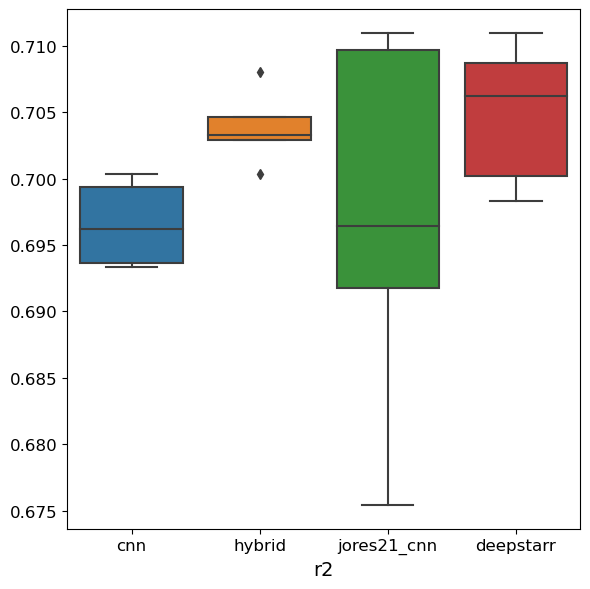

In [142]:
# Summarize performance across models for r2
leaf_model_scores = pl.performance_summary(
    sdata_leaf,
    target_key="enrichment",
    prediction_keys=preds_keys,
    prediction_groups=groups,
    metrics=["r2"],
    add_swarm=False,
    figsize=(6, 6),
    save=os.path.join(settings.figure_dir, "leaf", "leaf_performance_boxplot.pdf")
)

In [143]:
# Calculate significance of differences between groups
pairwise_tests = []
compare_df = leaf_model_scores.pivot(columns="prediction_groups", values="r2")
pairwise_tests.append(mannwhitneyu(compare_df["hybrid"].dropna(), compare_df["jores21_cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["hybrid"].dropna(), compare_df["cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["cnn"].dropna(), compare_df["jores21_cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["deepstarr"].dropna(), compare_df["jores21_cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["deepstarr"].dropna(), compare_df["cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["deepstarr"].dropna(), compare_df["hybrid"].dropna()).pvalue)
pairwise_tests = np.array(pairwise_tests)
multipletests(pairwise_tests, alpha=0.05, method="fdr_bh")

(array([False, False, False, False, False, False]),
 array([1.        , 0.0952381 , 1.        , 0.84126984, 0.16666667,
        1.        ]),
 0.008512444610847103,
 0.008333333333333333)

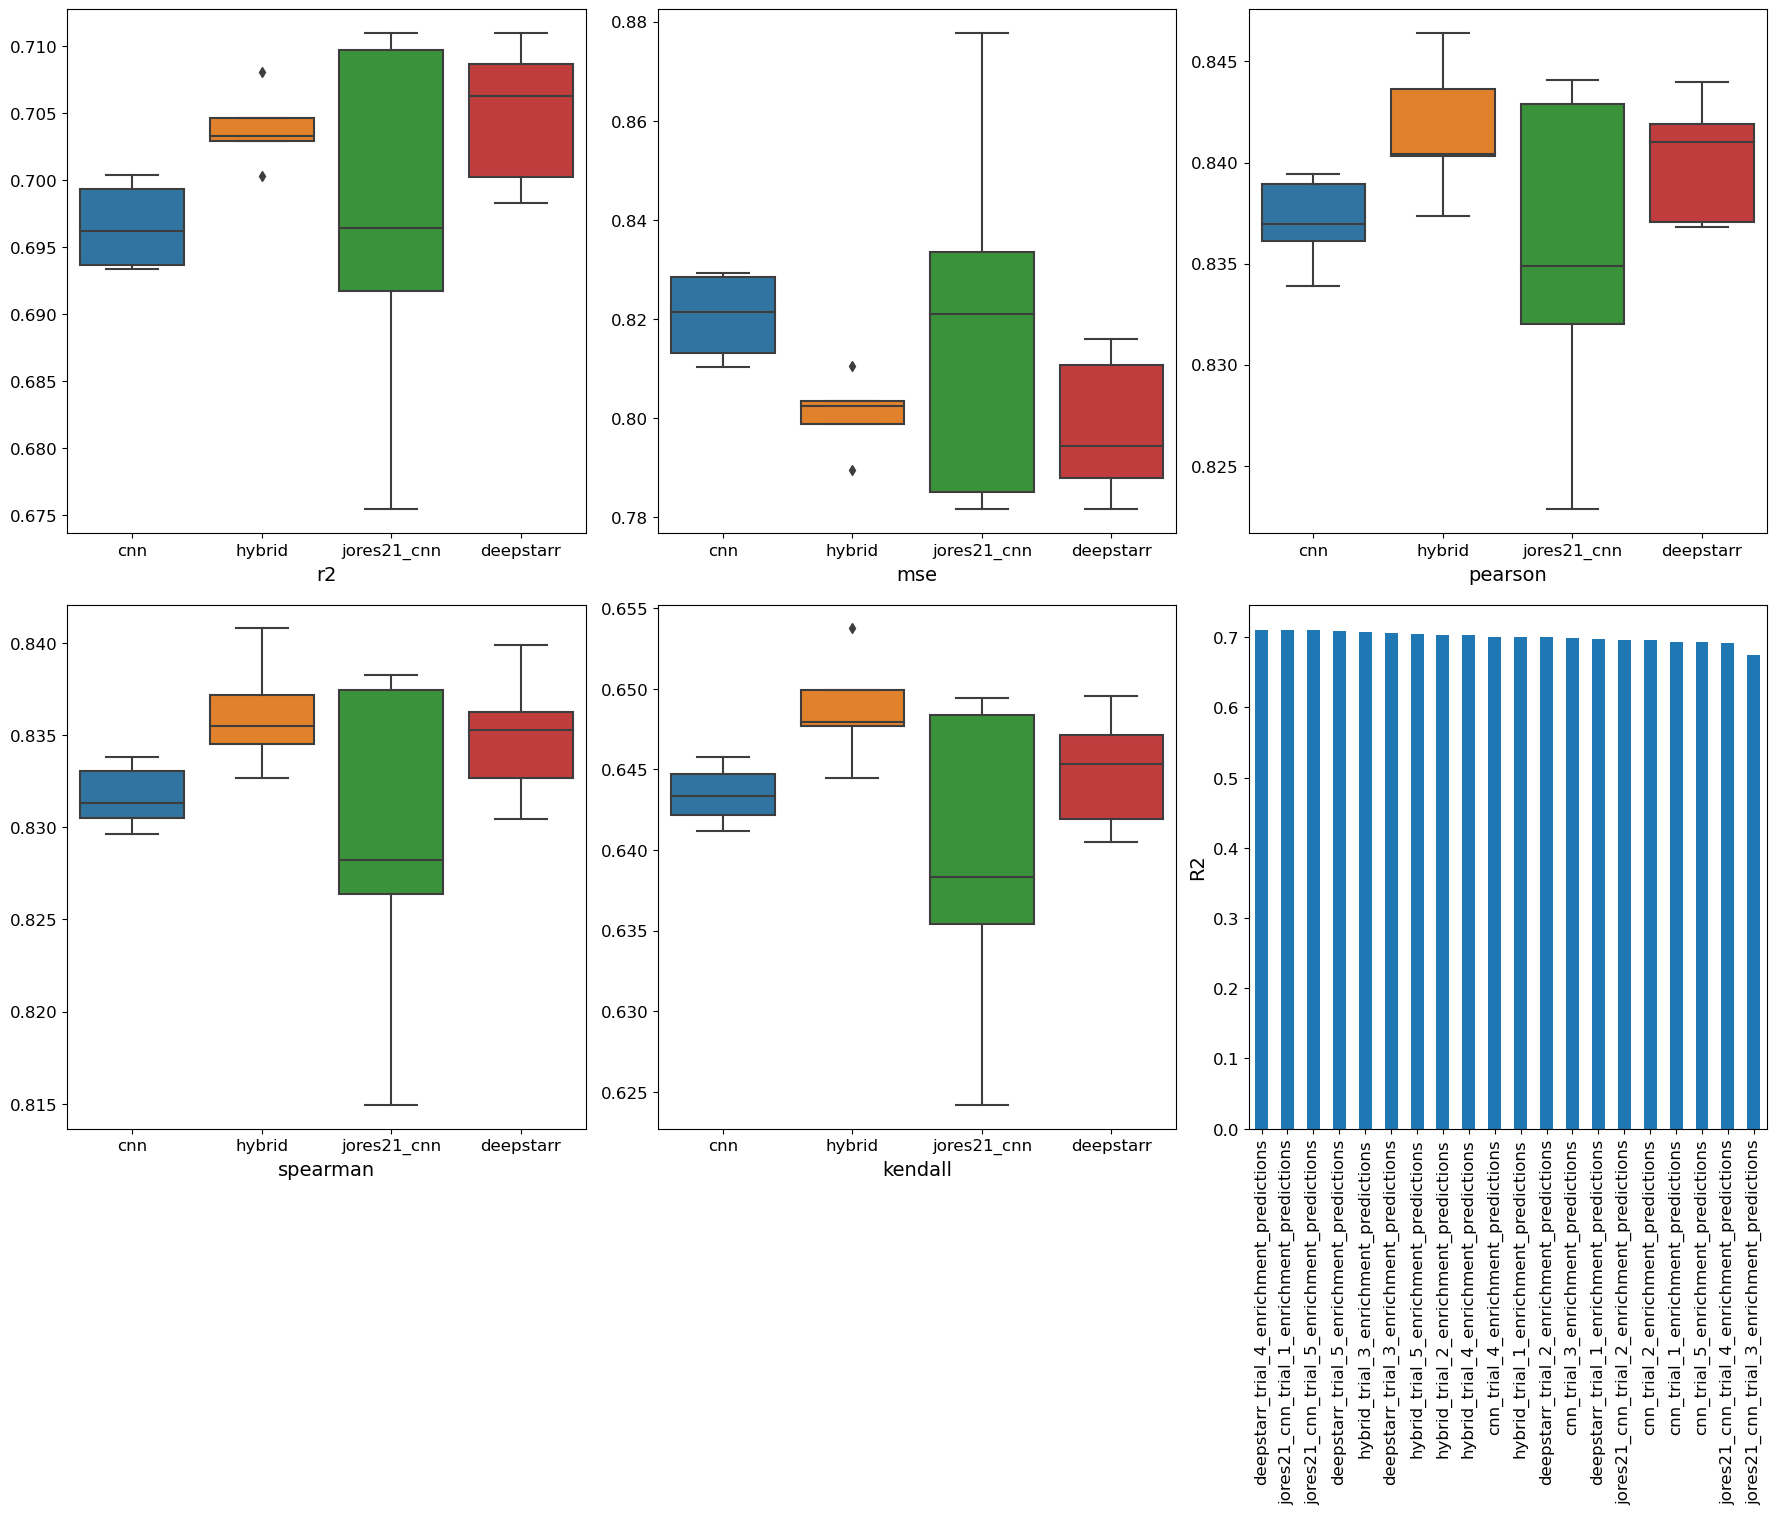

In [144]:
# Summarize performance across models for multiple metrics
leaf_model_scores = pl.performance_summary(
    sdata_leaf,
    target_key="enrichment",
    prediction_keys=preds_keys,
    prediction_groups=groups,
    metrics=["r2", "mse", "pearson", "spearman", "kendall"],
    add_swarm=False,
    figsize=(6, 6),
)

# Identify the best model from returned model scores
r2_sorted = leaf_model_scores["r2"].sort_values(ascending=False)
r2_sorted.plot(kind="bar", ylabel="R2")
plt.savefig(os.path.join(settings.figure_dir, "leaf", "leaf_performance_summary.pdf"))

In [145]:
# Save the performance summary as a table
leaf_model_scores.to_csv(os.path.join(settings.output_dir, "leaf", "leaf_performance_summary.tsv"), sep="\t")

Dropping 0 sequences with NaN targets.
Group R2 MSE Pearsonr Spearmanr
At 0.5489091334110499 0.6282952872213368 0.7220919970234563
Sb 0.6957506530946737 0.8260424237075816 0.8418062062125308
Zm 0.727033925030095 0.8311398318285521 0.8599135270312146


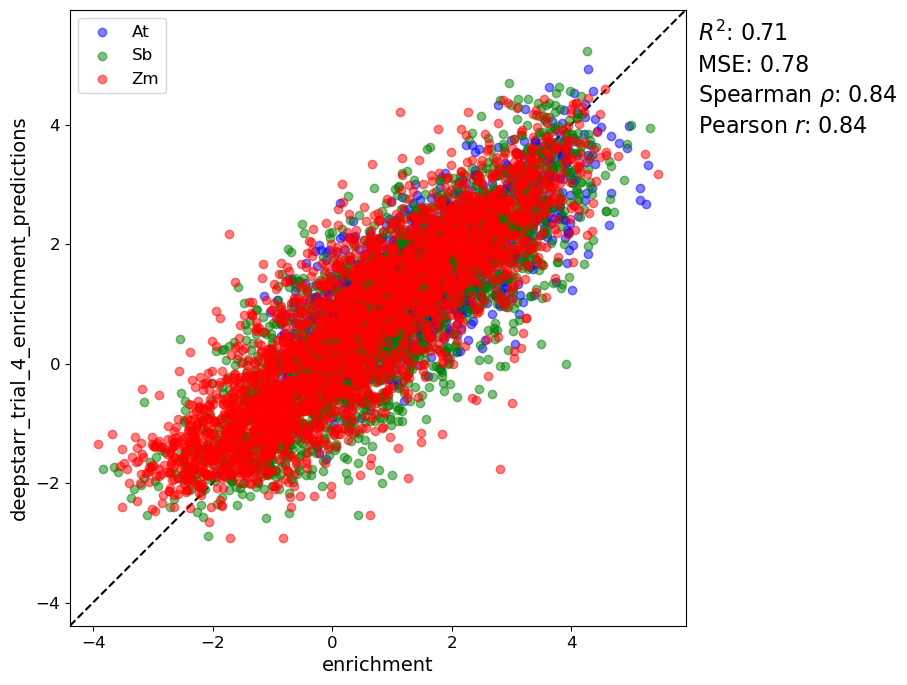

In [146]:
# Plot the performances across species for the best model
best_preds = r2_sorted.index[0]
ax = pl.performance_scatter(
    sdata_leaf, 
    target_keys="enrichment", 
    prediction_keys=best_preds,
    alpha=0.5,
    groupby="sp",
    figsize=(8, 8),
    rasterized=True,
    save=os.path.join(settings.figure_dir, "leaf", "leaf_best_model_performance_scatter_by_sp.pdf")
)

Dropping 0 sequences with NaN targets.


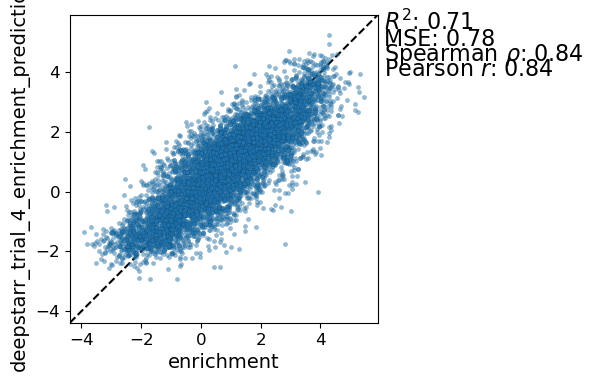

In [147]:
# Plot the performance for all species to use in Figure 2 
ax = pl.performance_scatter(
    sdata_leaf, 
    target_keys="enrichment", 
    prediction_keys=best_preds,
    alpha=0.5,
    figsize=(4, 4),
    rasterized=True,
    save=os.path.join(settings.figure_dir, "leaf", "leaf_best_model_performance_scatter.pdf")
)

## Proto models

In [148]:
# Read in the predictions 
proto_predictions = pd.read_csv(os.path.join(settings.output_dir, "proto", "jores21_proto_test_predictions.tsv"), sep="\t", index_col=0)
sdata_proto = sd.open_zarr(os.path.join(settings.output_dir, "proto", "jores21_proto_test_predictions.zarr")).load()

In [149]:
# Get only variables with "predictions" in the name
preds_keys = [k for k in sdata_proto.keys() if "predictions" in k]

# Order the pred_keys from in this order ["cnn", "hyrbrid", "jores21_cnn", "deepstarr"]
order = ["cnn", "hybrid", "jores21_cnn", "deepstarr"]
pred_models = [k.split("_")[0] if "jores21" not in k else "jores21_cnn" for k in preds_keys]
pred_models = [order.index(m) for m in pred_models]
preds_keys = [k for _, k in sorted(zip(pred_models, preds_keys))]

# Get groups based io
model_groups = {"cnn": "cnn", "hybrid": "hybrid", "jores21_cnn": "jores21_cnn", "deepstarr": "deepstarr"}
groups = [model_groups[k.split("_")[0]] if "jores21" not in k else "jores21_cnn" for k in preds_keys]

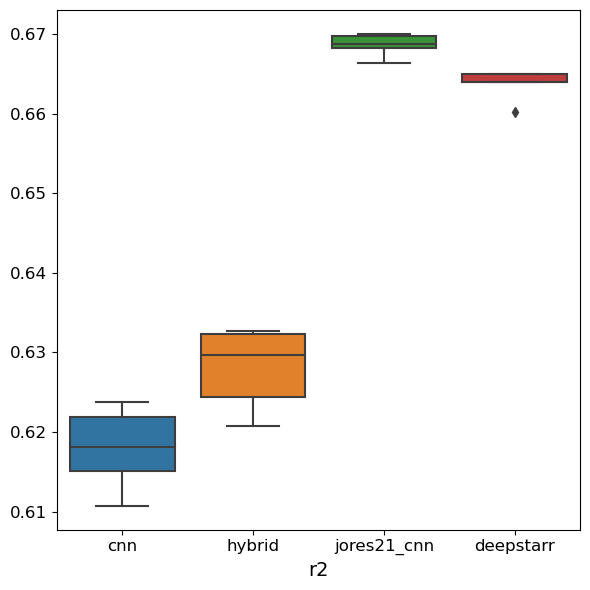

In [150]:
# Summarize performance across models for r2
proto_model_scores = pl.performance_summary(
    sdata_proto,
    target_key="enrichment",
    prediction_keys=preds_keys,
    prediction_groups=groups,
    metrics=["r2"],
    add_swarm=False,
    figsize=(6, 6),
    save=os.path.join(settings.figure_dir, "proto", "proto_performance_boxplot.pdf")
)

In [151]:
# Calculate significance of differences between groups
pairwise_tests = []
compare_df = proto_model_scores.pivot(columns="prediction_groups", values="r2")
pairwise_tests.append(mannwhitneyu(compare_df["hybrid"].dropna(), compare_df["jores21_cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["hybrid"].dropna(), compare_df["cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["cnn"].dropna(), compare_df["jores21_cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["deepstarr"].dropna(), compare_df["jores21_cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["deepstarr"].dropna(), compare_df["cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["deepstarr"].dropna(), compare_df["hybrid"].dropna()).pvalue)
pairwise_tests = np.array(pairwise_tests)
multipletests(pairwise_tests, alpha=0.05, method="fdr_bh")

(array([ True,  True,  True,  True,  True,  True]),
 array([0.00952381, 0.03174603, 0.00952381, 0.00952381, 0.00952381,
        0.00952381]),
 0.008512444610847103,
 0.008333333333333333)

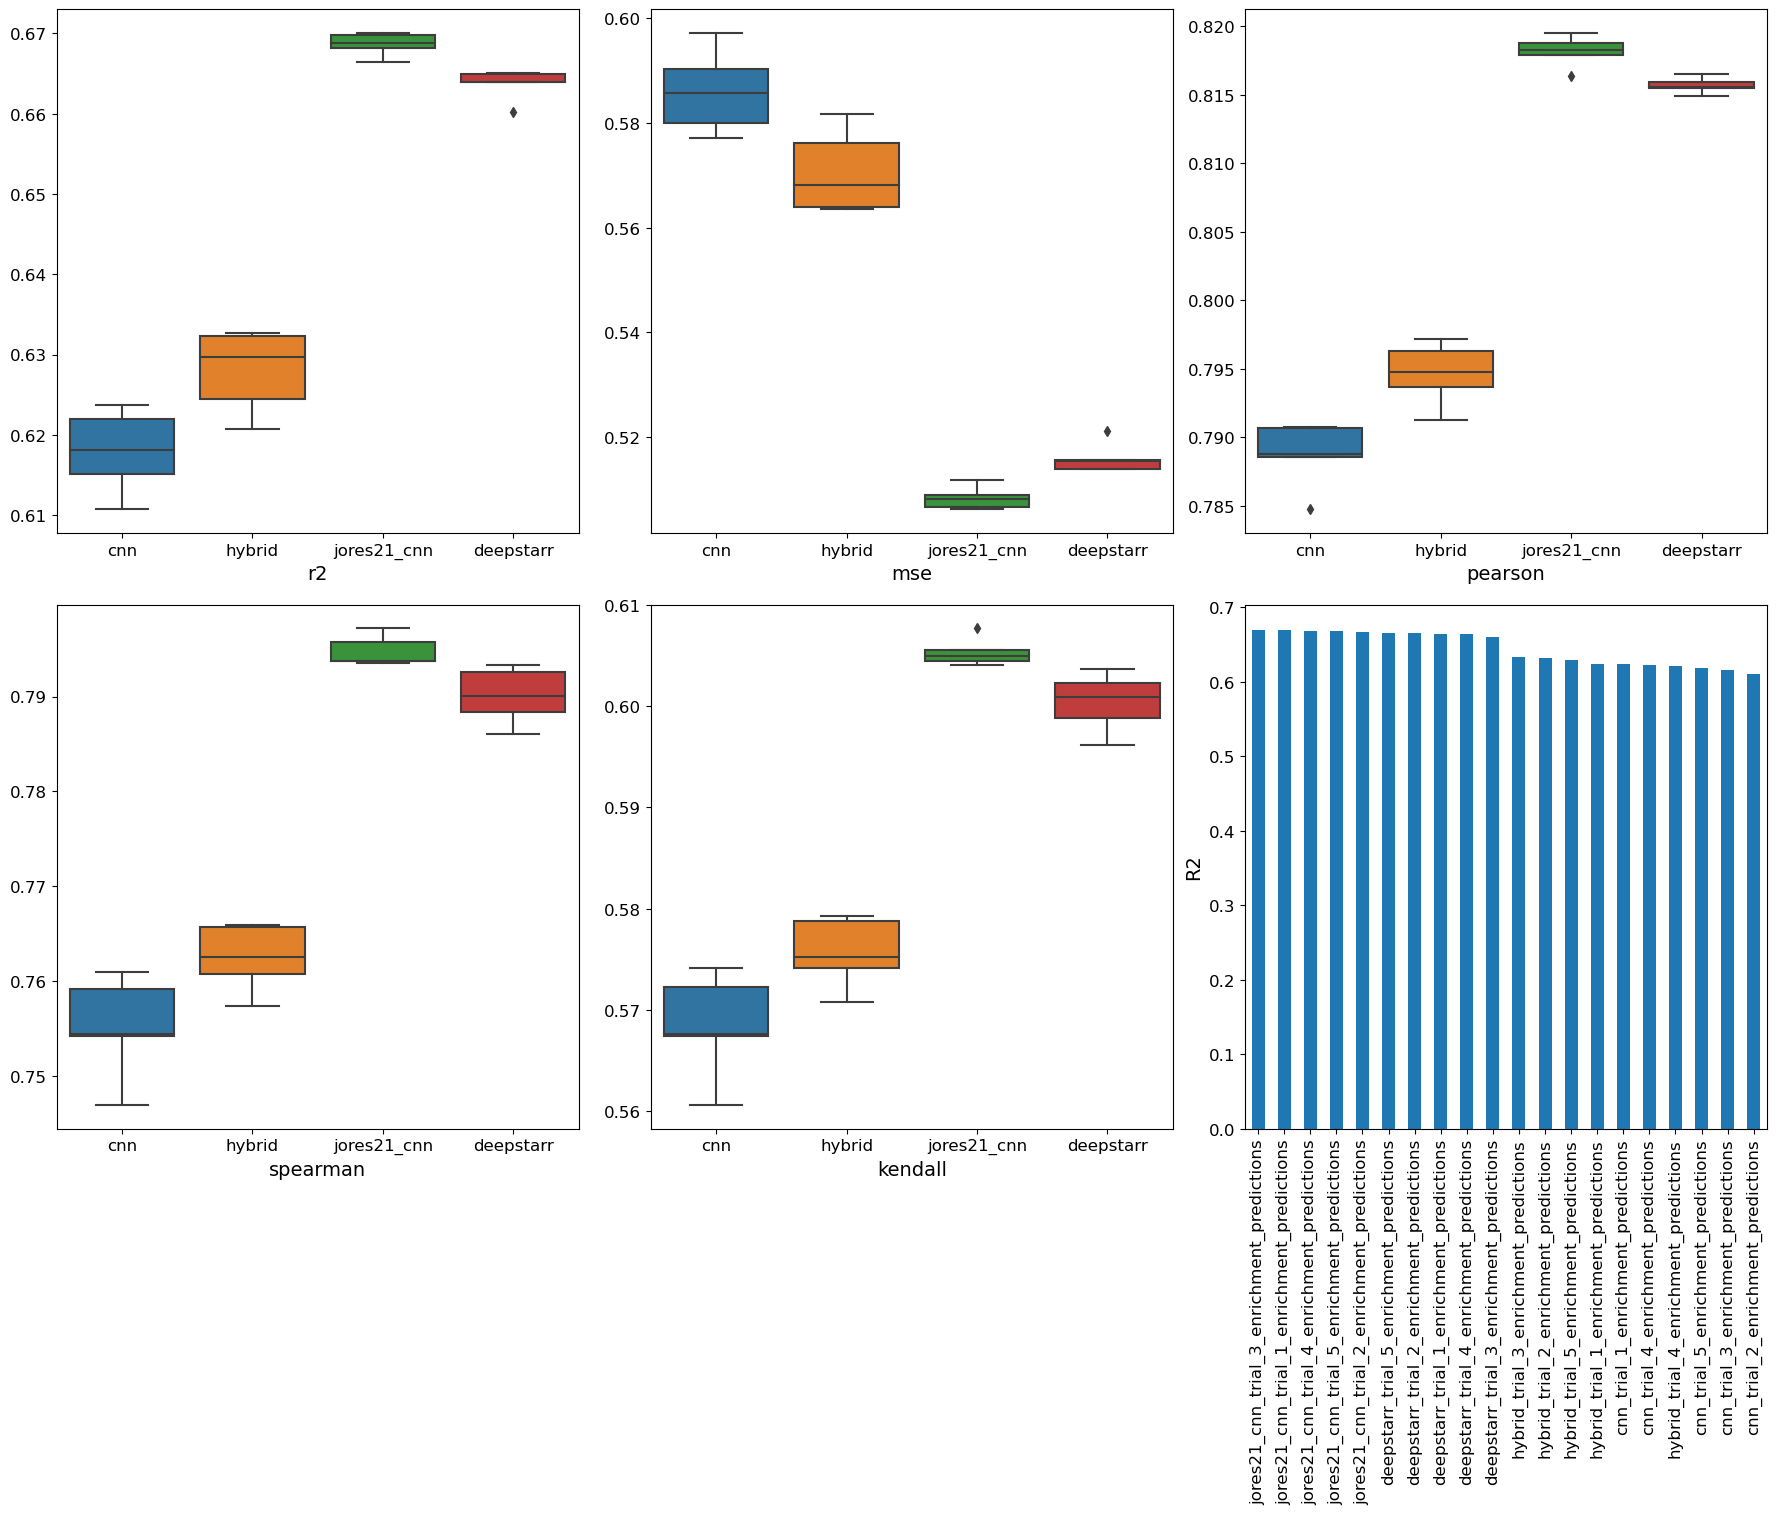

In [152]:
# Summarize performance across models for multiple metrics
proto_model_scores = pl.performance_summary(
    sdata_proto,
    target_key="enrichment",
    prediction_keys=preds_keys,
    prediction_groups=groups,
    metrics=["r2", "mse", "pearson", "spearman", "kendall"],
    add_swarm=False,
    figsize=(6, 6),
)

# Identify the best model from returned model scores
r2_sorted = proto_model_scores["r2"].sort_values(ascending=False)
r2_sorted.plot(kind="bar", ylabel="R2")
plt.savefig(os.path.join(settings.figure_dir, "proto", "proto_performance_summary.pdf"))

In [153]:
# Save the performance summary as a table
proto_model_scores.to_csv(os.path.join(settings.output_dir, "proto", "proto_performance_summary.tsv"), sep="\t")

Dropping 0 sequences with NaN targets.
Group R2 MSE Pearsonr Spearmanr
At 0.5569149815672504 0.6397362184776952 0.7373255114995868
Sb 0.6123468957084701 0.4864429128492309 0.752903787689184
Zm 0.6761575317553229 0.4530093903328288 0.8102424855737913


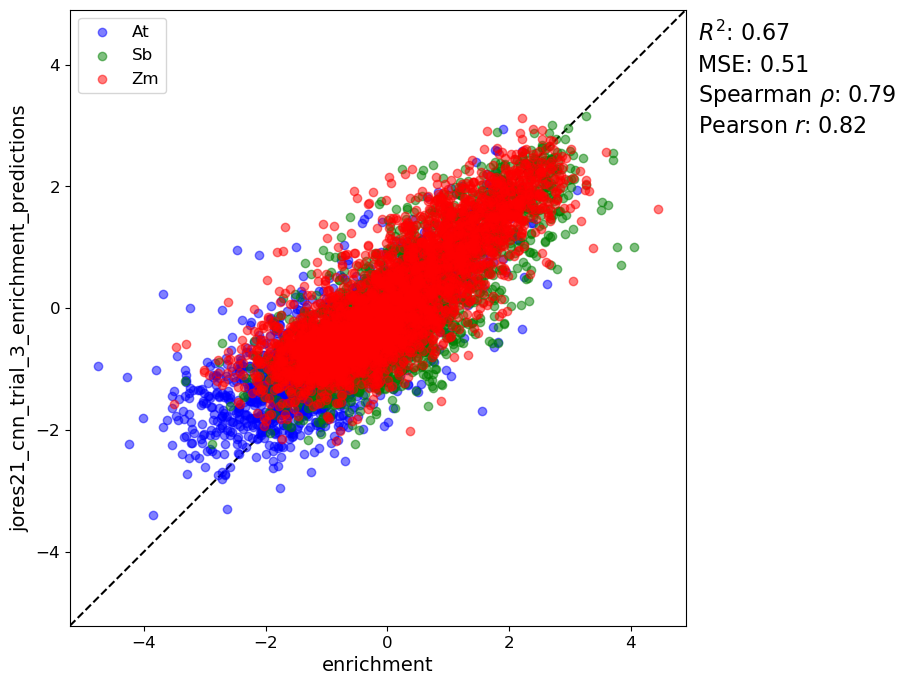

In [154]:
# Plot the performances across species for the best model
best_preds = r2_sorted.index[0]
ax = pl.performance_scatter(
    sdata_proto, 
    target_keys="enrichment", 
    prediction_keys=best_preds,
    alpha=0.5,
    groupby="sp",
    figsize=(8, 8),
    rasterized=True,
    save=os.path.join(settings.figure_dir, "proto", "proto_best_model_performance_scatter_by_sp.pdf")
)

Dropping 0 sequences with NaN targets.


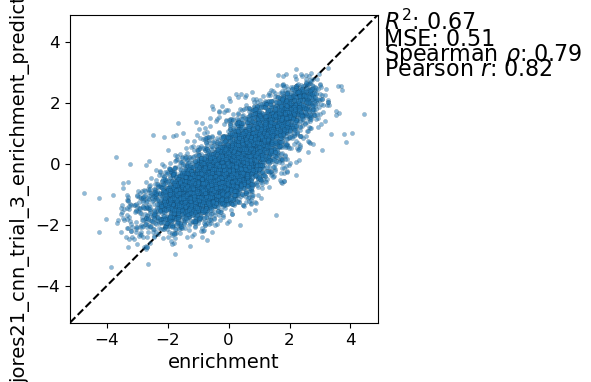

In [155]:
# Plot the performance for all species to use in Figure 2 
ax = pl.performance_scatter(
    sdata_proto, 
    target_keys="enrichment", 
    prediction_keys=best_preds,
    alpha=0.5,
    figsize=(4, 4),
    rasterized=True,
    save=os.path.join(settings.figure_dir, "proto", "proto_best_model_performance_scatter.pdf")
)

## Combined models

In [156]:
# Read in the predictions 
combined_predictions = pd.read_csv(os.path.join(settings.output_dir, "combined", "jores21_combined_test_predictions.tsv"), sep="\t", index_col=0)
sdata_combined = sd.open_zarr(os.path.join(settings.output_dir, "combined", "jores21_combined_test_predictions.zarr")).load()

In [157]:
# Get only variables with "predictions" in the name
preds_keys = [k for k in sdata_combined.keys() if "predictions" in k]

# Order the pred_keys from in this order ["cnn", "hyrbrid", "jores21_cnn", "deepstarr"]
order = ["cnn", "hybrid", "jores21_cnn", "deepstarr"]
pred_models = [k.split("_")[0] if "jores21" not in k else "jores21_cnn" for k in preds_keys]
pred_models = [order.index(m) for m in pred_models]
preds_keys = [k for _, k in sorted(zip(pred_models, preds_keys))]

# Get groups based io
model_groups = {"cnn": "cnn", "hybrid": "hybrid", "jores21_cnn": "jores21_cnn", "deepstarr": "deepstarr"}
groups = [model_groups[k.split("_")[0]] if "jores21" not in k else "jores21_cnn" for k in preds_keys]

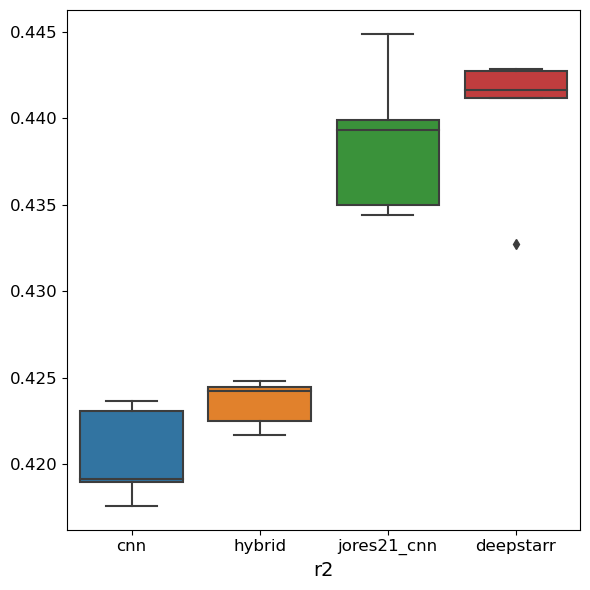

In [158]:
# Summarize performance across models for r2
combined_model_scores = pl.performance_summary(
    sdata_combined,
    target_key="enrichment",
    prediction_keys=preds_keys,
    prediction_groups=groups,
    metrics=["r2"],
    add_swarm=False,
    figsize=(6, 6),
    save=os.path.join(settings.figure_dir, "combined", "combined_performance_boxplot.pdf")
)

In [159]:
# Calculate significance of differences between groups
pairwise_tests = []
compare_df = combined_model_scores.pivot(columns="prediction_groups", values="r2")
pairwise_tests.append(mannwhitneyu(compare_df["hybrid"].dropna(), compare_df["jores21_cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["hybrid"].dropna(), compare_df["cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["cnn"].dropna(), compare_df["jores21_cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["deepstarr"].dropna(), compare_df["jores21_cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["deepstarr"].dropna(), compare_df["cnn"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["deepstarr"].dropna(), compare_df["hybrid"].dropna()).pvalue)
pairwise_tests = np.array(pairwise_tests)
multipletests(pairwise_tests, alpha=0.05, method="fdr_bh")

(array([ True, False,  True, False,  True,  True]),
 array([0.01190476, 0.11428571, 0.01190476, 0.54761905, 0.01190476,
        0.01190476]),
 0.008512444610847103,
 0.008333333333333333)

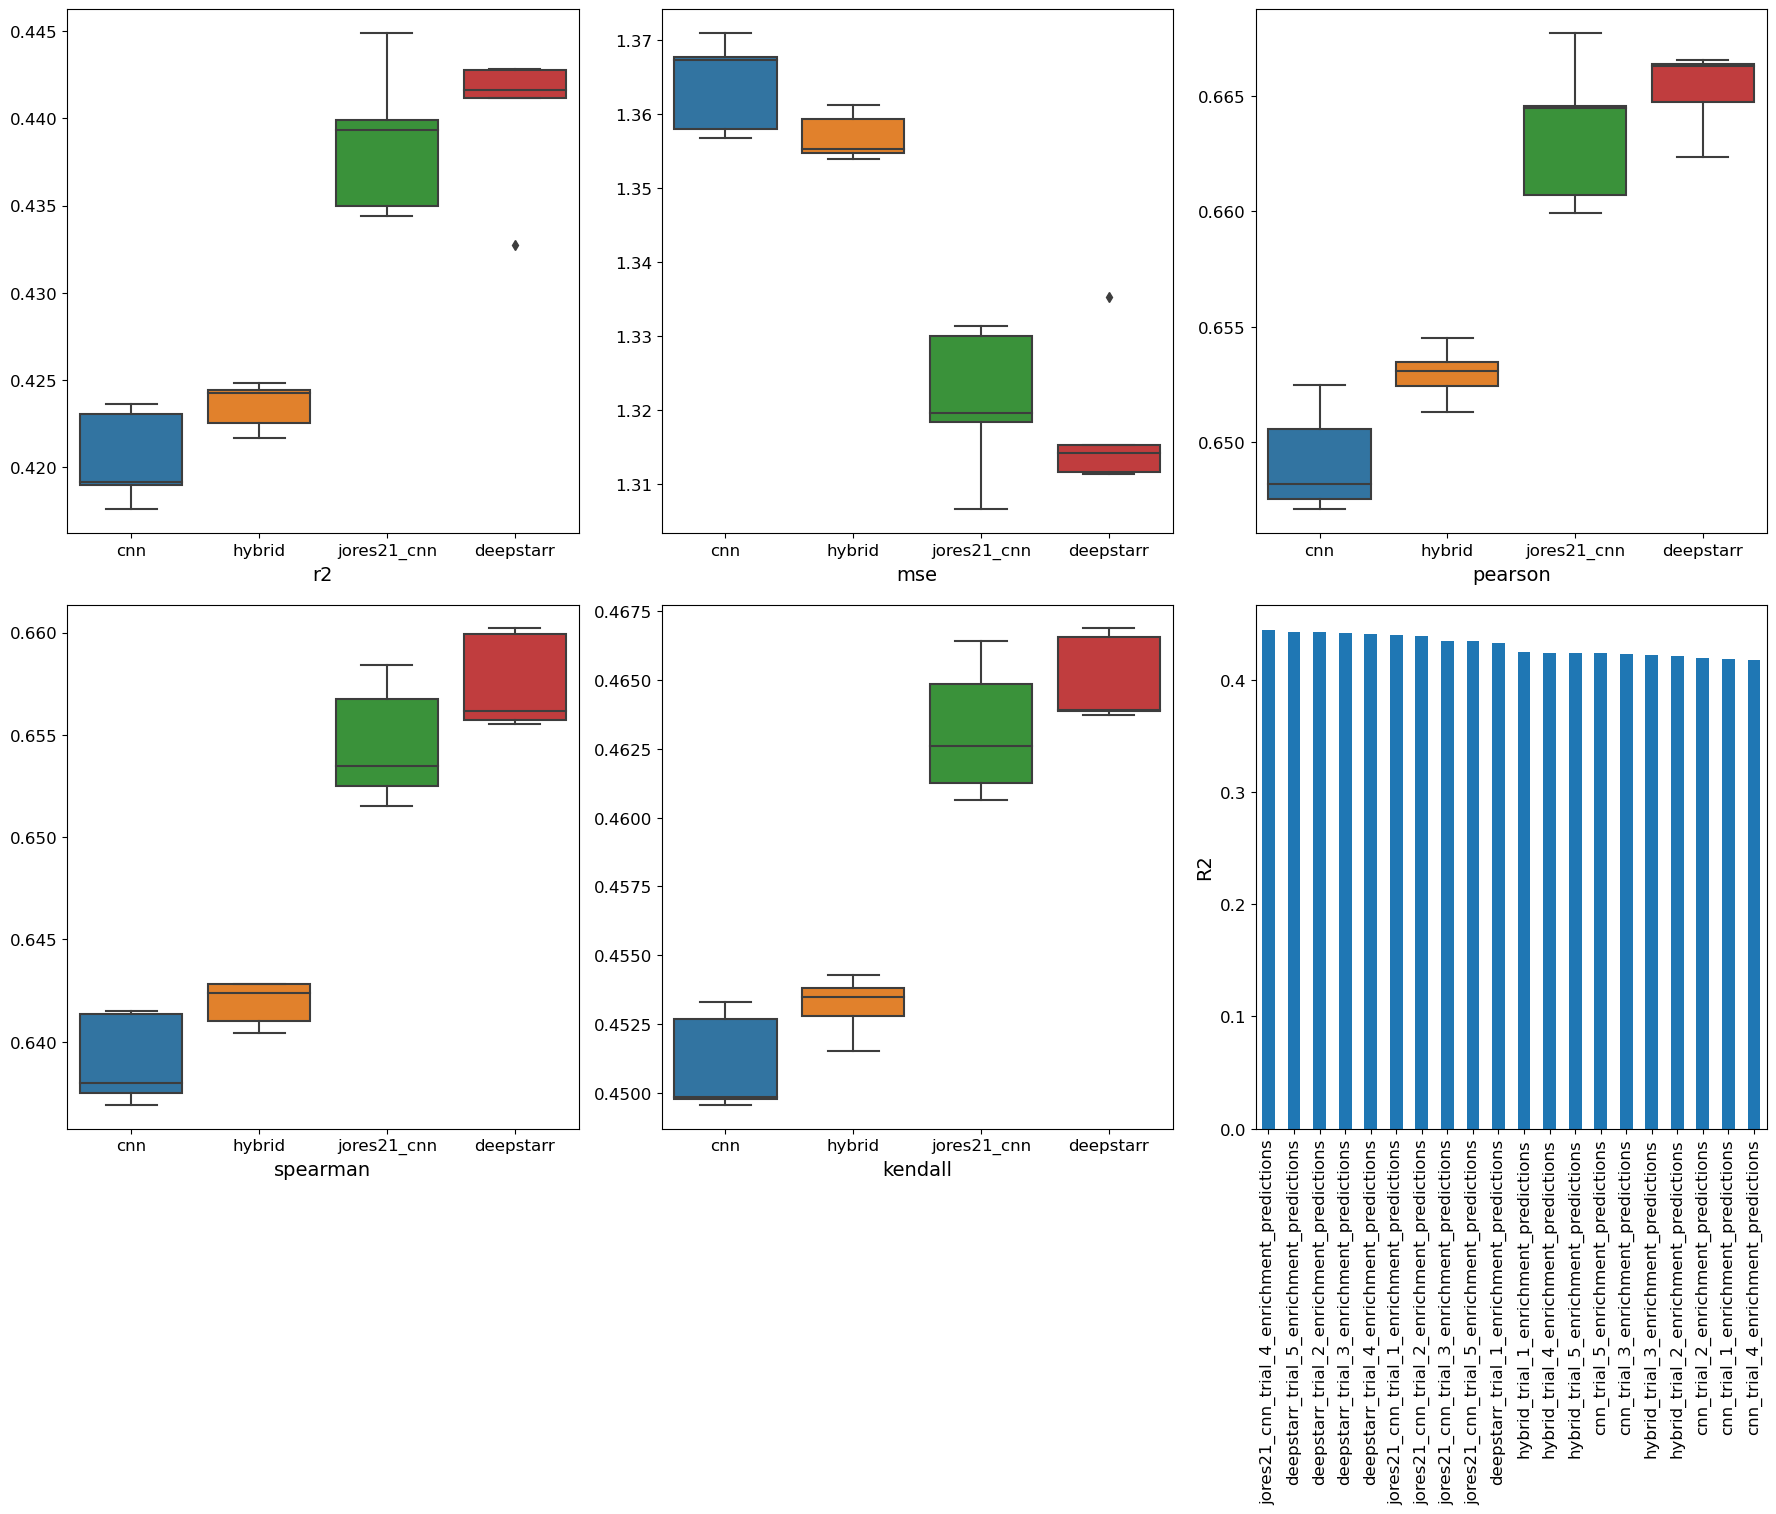

In [164]:
# Summarize performance across models for multiple metrics
combined_model_scores = pl.performance_summary(
    sdata_combined,
    target_key="enrichment",
    prediction_keys=preds_keys,
    prediction_groups=groups,
    metrics=["r2", "mse", "pearson", "spearman", "kendall"],
    add_swarm=False,
    figsize=(6, 6),
)

# Identify the best model from returned model scores
r2_sorted = combined_model_scores["r2"].sort_values(ascending=False)
r2_sorted.plot(kind="bar", ylabel="R2")
plt.savefig(os.path.join(settings.figure_dir, "combined", "combined_performance_summary.pdf"))

In [165]:
# Save the performance summary as a table
combined_model_scores.to_csv(os.path.join(settings.output_dir, "combined", "combined_performance_summary.tsv"), sep="\t")

Dropping 0 sequences with NaN targets.
Group R2 MSE Pearsonr Spearmanr
At 0.2114530140919738 2.264288120922449 0.4291404655549834
Sb 0.5023126440450614 1.0499382615040322 0.7087842725616265
Zm 0.5524864098167985 0.9998580068565617 0.7458652905281711


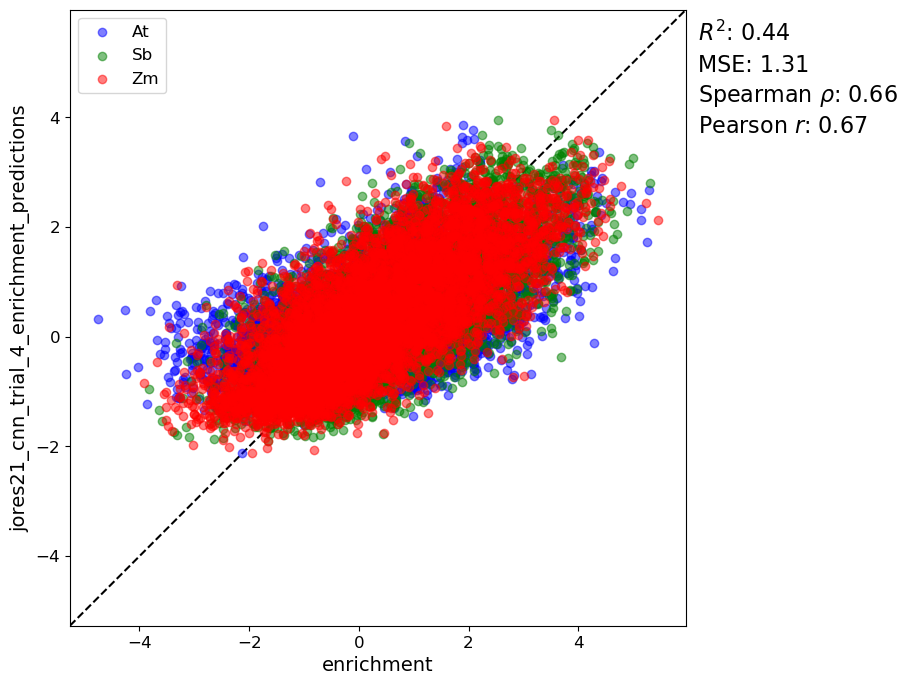

In [166]:
# Plot the performances across species for the best model
best_preds = r2_sorted.index[0]
ax = pl.performance_scatter(
    sdata_combined, 
    target_keys="enrichment", 
    prediction_keys=best_preds,
    alpha=0.5,
    groupby="sp",
    figsize=(8, 8),
    rasterized=True,
    save=os.path.join(settings.figure_dir, "combined", "combined_best_model_performance_scatter_by_sp.pdf")
)

Dropping 0 sequences with NaN targets.


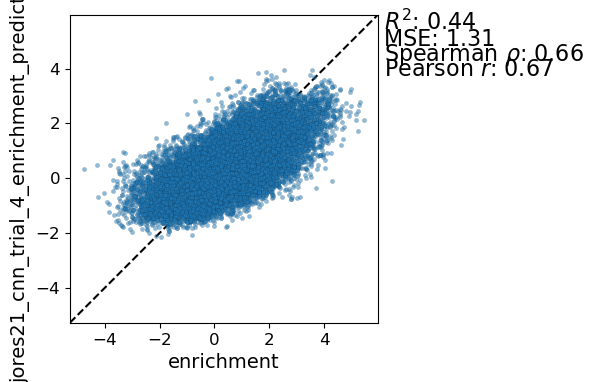

In [167]:
# Plot the performance for all species to use in Figure 2 
ax = pl.performance_scatter(
    sdata_combined, 
    target_keys="enrichment", 
    prediction_keys=best_preds,
    alpha=0.5,
    figsize=(4, 4),
    rasterized=True,
    save=os.path.join(settings.figure_dir, "combined", "combined_best_model_performance_scatter.pdf")
)

# Performance summary table

In [49]:
# Combined everything into one dataframe
leaf_model_scores["model"] = "leaf"
proto_model_scores["model"] = "proto"
combined_model_scores["model"] = "combined"
merged_model_scores = pd.concat([leaf_model_scores, proto_model_scores, combined_model_scores])
merged_model_scores.to_csv(os.path.join(settings.output_dir, "merged_performance_summary.tsv"), sep="\t")

# Cleaner seq track logos

In [168]:
# Set-up model
model = "leaf"
trial = 5
model_type = "hybrid"

In [170]:
# Load in importances
sdata_interpretations = sd.open_zarr(os.path.join(settings.output_dir, model, f"{model}_test_predictions_and_interpretations.zarr"))

In [171]:
# Grab the highest predicted seqs for the best model
top5 = sdata_interpretations[f"{model_type}_trial_{trial}_enrichment_predictions"].to_series().sort_values(ascending=False).iloc[:5].index
top5_idx = np.argsort(sdata_interpretations[f"{model_type}_trial_{trial}_enrichment_predictions"].values)[::-1][:5]

In [173]:
# Find the ranges in each seq where the model gives high interpretations
seq_num, seq_pos = np.where(np.sum(sdata_interpretations["DeepLift_attrs"].values[top5_idx], axis=1) > 0.01)
ranges = []

# Find the continuous ranges of high interpretation that are longer than 3 and allow for multiple ranges per seq
for i in np.unique(seq_num):
    ranges_i = []
    for k, g in groupby(enumerate(seq_pos[seq_num == i]), lambda x: x[0] - x[1]):
        group = list(map(itemgetter(1), g))
        if len(group) > 3:
            ranges_i.append((group[0], group[-1]))
    ranges.append(ranges_i)
ranges

[[(143, 151)],
 [(75, 78), (131, 140)],
 [(128, 133)],
 [(121, 129)],
 [(125, 128)]]

(143, 151)
(75, 78)
(131, 140)
(128, 133)
(121, 129)
(125, 128)


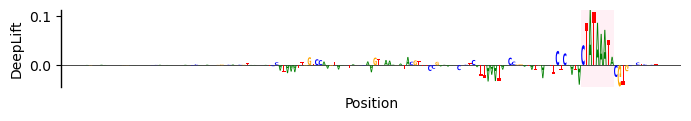

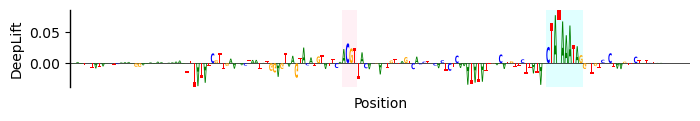

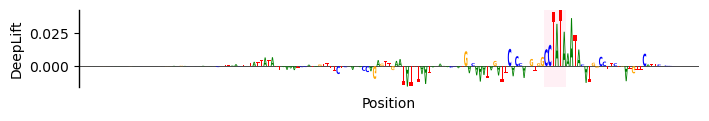

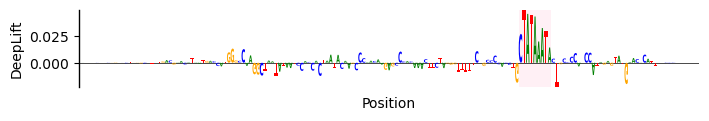

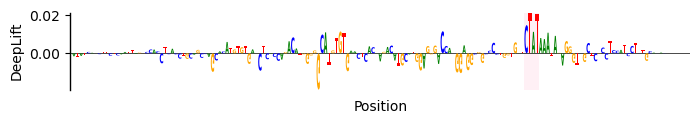

In [192]:
# Plot the top 5 with the ranges
ids = sdata_interpretations["id"].values[top5_idx]
for i in range(5):
    pl.seq_track(
        sdata_interpretations,
        seq_id=ids[i],
        attrs_key="DeepLift_attrs",
        ylab="DeepLift",
        highlights=ranges[i],
        figsize=(8, 1),
        save=os.path.join(settings.figure_dir, model, f"{model}_best_model_feature_attr_{i+1}.pdf"),
    )

# TomTom annotation analysis

In [248]:
# Which model?
model = "proto"
trial = 5
model_type = "jores21_cnn"

In [249]:
# Grab and combine the results from annotating CPEs and TF clusters
tomtom_cpe = pd.read_csv(os.path.join(settings.output_dir, model, f"{model}_best_model_filters_tomtom_CPE.tsv"), sep="\t")
tomtom_tf = pd.read_csv(os.path.join(settings.output_dir, model, f"{model}_best_model_filters_tomtom_TF.tsv"), sep="\t")
tomtom_df = pd.concat([tomtom_cpe, tomtom_tf], axis=0)

In [250]:
# Save as a dataframe
tomtom_df.to_csv(os.path.join(settings.output_dir, model, f"{model}_best_model_filters_tomtom.tsv"), sep="\t")

In [251]:
# Subset to significant hits
tomtom_sig = tomtom_df[tomtom_df["q-value"] <= 0.05]

In [252]:
# Add the filter number as a column
tomtom_sig["filter_num"] = tomtom_sig["Query_ID"].str.split("filter_").str[-1].astype(int)

/tmp/ipykernel_2008684/1206503378.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tomtom_sig["filter_num"] = tomtom_sig["Query_ID"].str.split("filter_").str[-1].astype(int)


In [253]:
# Separate into filters that were instantiated and those that were purely learned
tomtom_sig_init = tomtom_sig[tomtom_sig["filter_num"] <= 77]
tomtom_sig_learned = tomtom_sig[tomtom_sig["filter_num"] > 77]

In [254]:
# How many of the original filters returned significant hits?
len(tomtom_sig_init["Target_ID"].unique())

70

In [255]:
# Separate the instantiated filters into CPE and TF hits
tomtom_sig_init_tf = tomtom_sig_init[tomtom_sig_init["Target_ID"].str.contains("TF")]
tomtom_sig_init_cpe = tomtom_sig_init[(tomtom_sig_init["Target_ID"].str.contains("TF") == False)]

In [256]:
# Get the cluster numbers for the TF hits
tomtom_sig_init_tf["TF_cluster_number"] = tomtom_sig_init_tf["Target_ID"].str.split("_").str[-1]
tomtom_sig_init_tf["TF_cluster_number"] = tomtom_sig_init_tf["TF_cluster_number"].astype(int)

/tmp/ipykernel_2008684/874153263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tomtom_sig_init_tf["TF_cluster_number"] = tomtom_sig_init_tf["Target_ID"].str.split("_").str[-1]
/tmp/ipykernel_2008684/874153263.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tomtom_sig_init_tf["TF_cluster_number"] = tomtom_sig_init_tf["TF_cluster_number"].astype(int)


In [257]:
# See how many of the initialized TF clusters remained significant to their initialization
(tomtom_sig_init_tf["TF_cluster_number"] + 5 == tomtom_sig_init_tf["filter_num"]).sum()

65

In [258]:
# Generate a naming map for plotting
core_promoter_elements = md.read_meme(os.path.join(settings.dataset_dir, 'CPEs.meme'))
tf_clusters = md.read_meme(os.path.join(settings.dataset_dir, 'TF-clusters.meme'))

# Smush them together, make function in the future
all_motifs = deepcopy(core_promoter_elements)
for motif in tf_clusters:
    all_motifs.add_motif(motif)
all_motifs
id_map = {}
for motif in all_motifs:
    id_map[motif.identifier] = motif.name

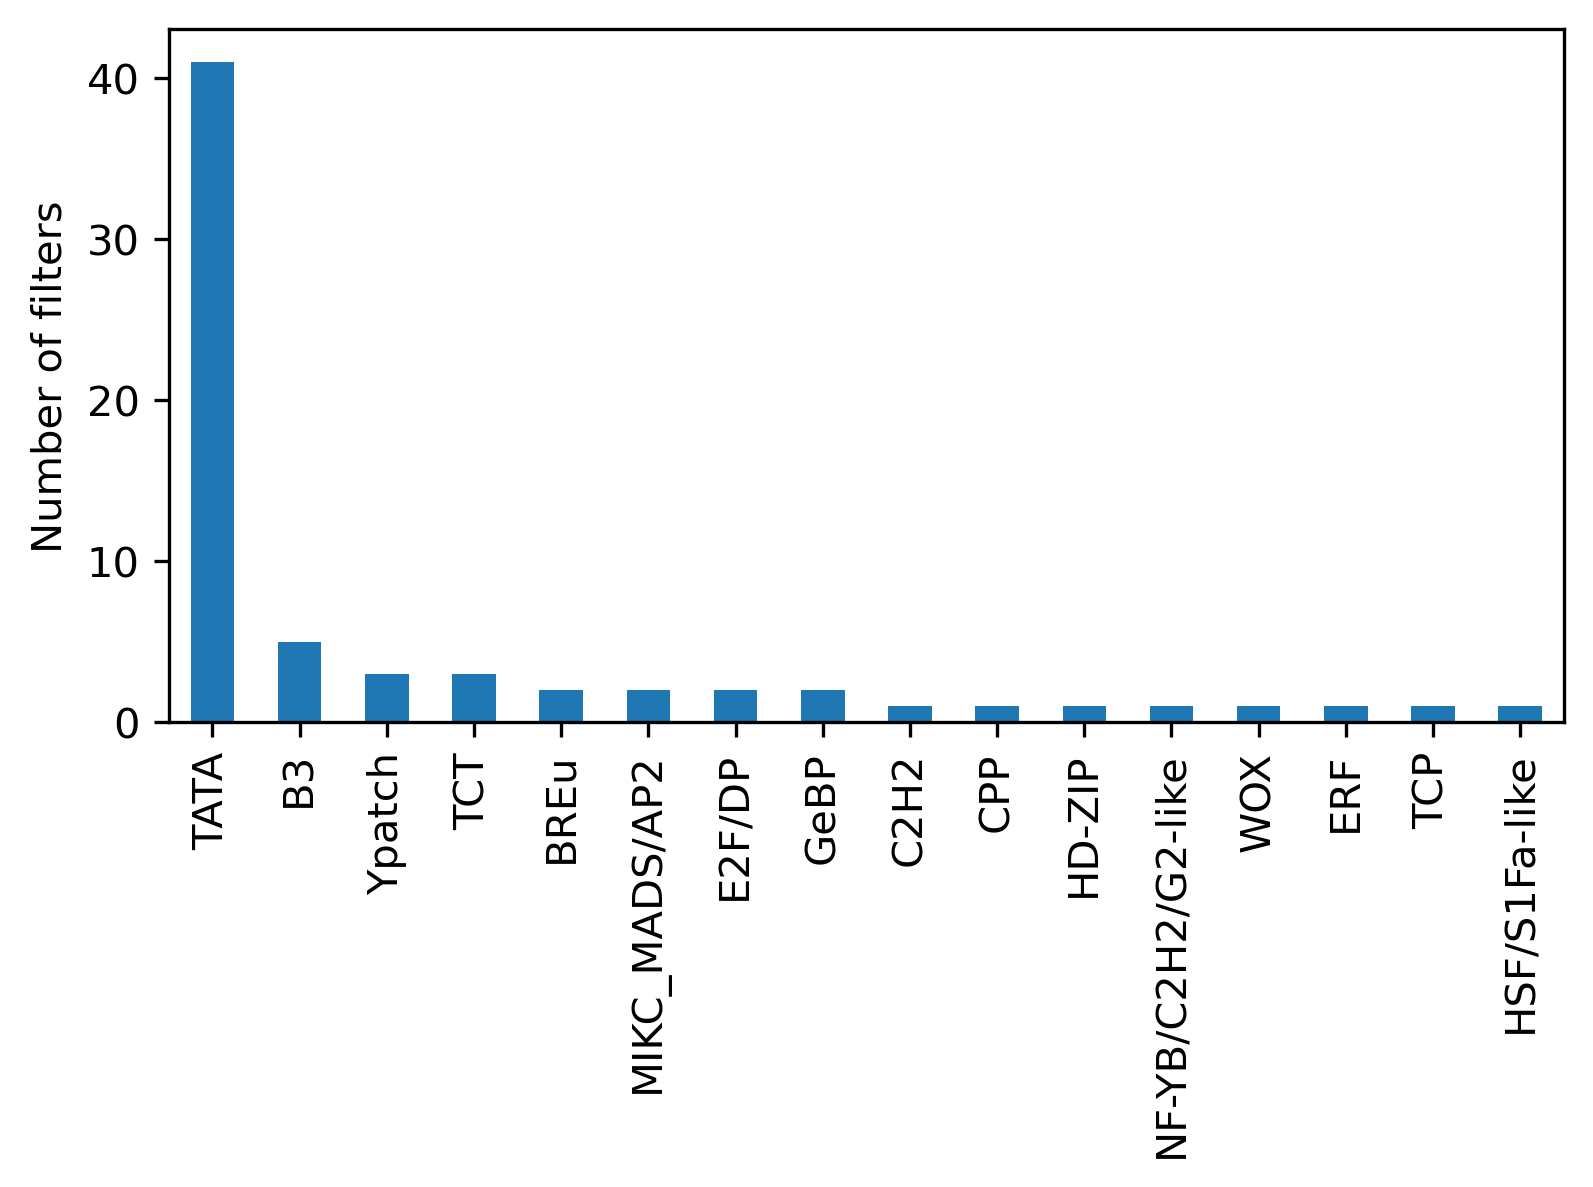

In [259]:
# Plot the frequencies of hits to motifs in the learned filters
plt.figure(figsize=(6, 3), dpi=300)
tomtom_sig_learned["Target_ID"].map(id_map).value_counts().plot(kind="bar", ylabel="Number of filters")
plt.savefig(os.path.join(settings.figure_dir, model, f"{model}_best_model_filters_tomtom_barplot.pdf"))

In [260]:
# Get the most significant hits to each motif
top_tomtom_sig_learned = tomtom_sig_learned.sort_values("q-value").groupby("Target_ID").head(1)
top_tomtom_sig_learned.to_csv(os.path.join(settings.output_dir, model, f"{model}_best_model_filters_tomtom_top_hits.tsv"), sep="\t")

In [261]:
# Hits
idxs = top_tomtom_sig_learned["filter_num"].values
hit_names = top_tomtom_sig_learned["Target_ID"].map(id_map).values

In [271]:
# Load in importances
sdata_interpretations = sd.open_zarr(os.path.join(settings.output_dir, model, f"{model}_test_predictions_and_interpretations.zarr"))

In [272]:
# Grab the key for the pfms
keys = pd.Index(sdata_interpretations.data_vars.keys())
pfm_key = keys[keys.str.contains("pfms")].values[0]
pfm_key

'arch.biconv_pfms'

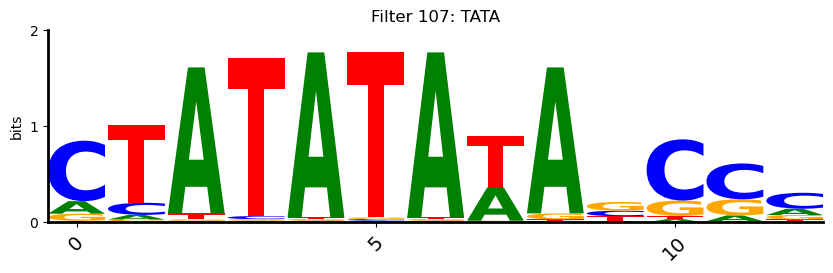

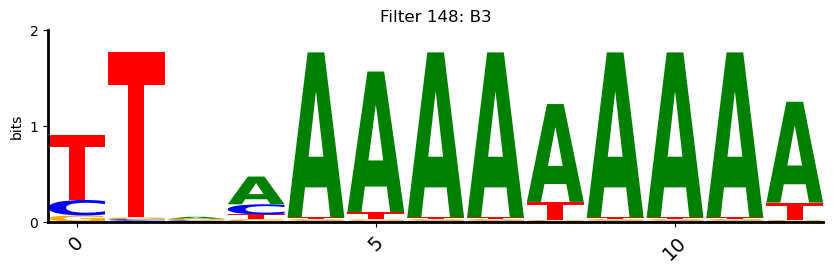

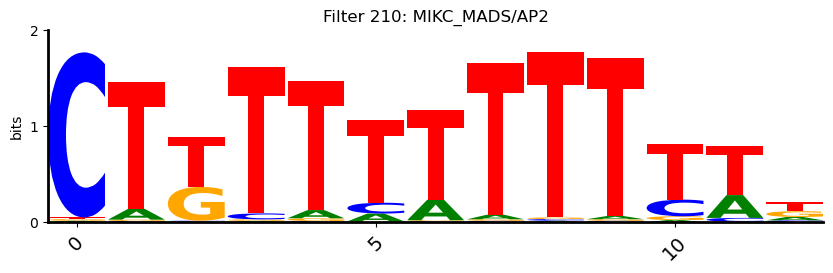

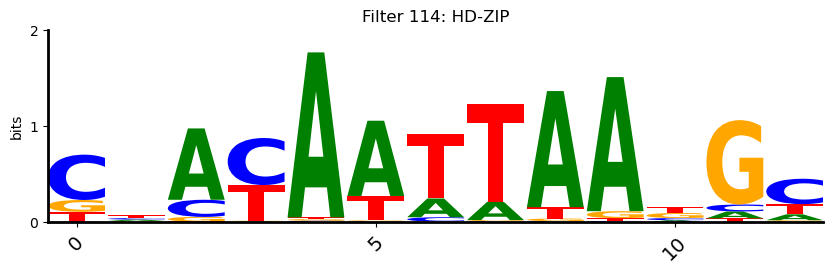

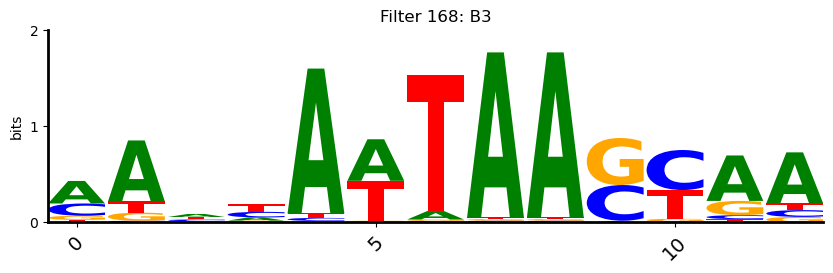

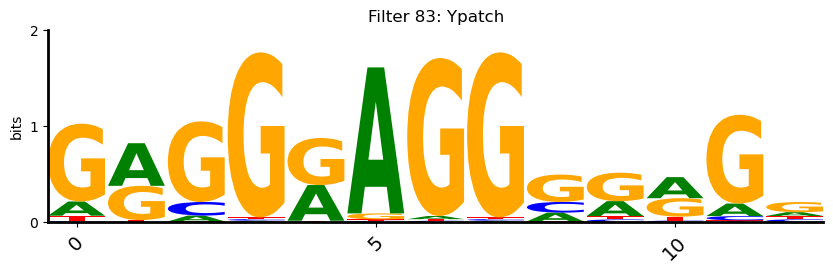

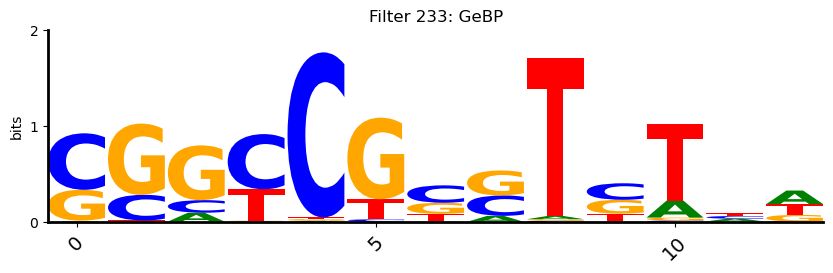

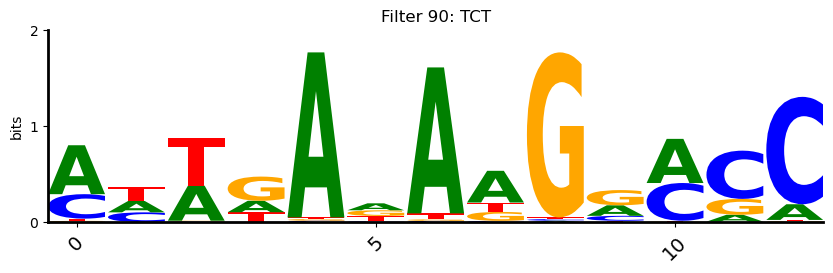

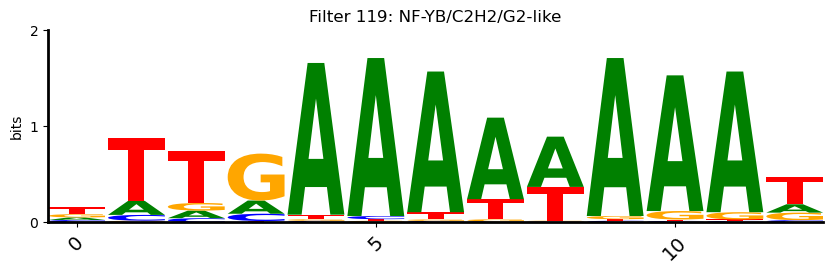

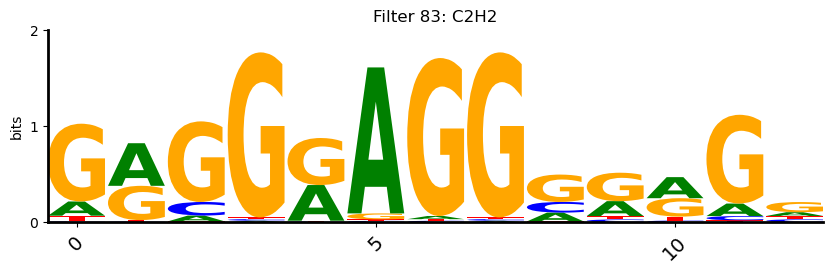

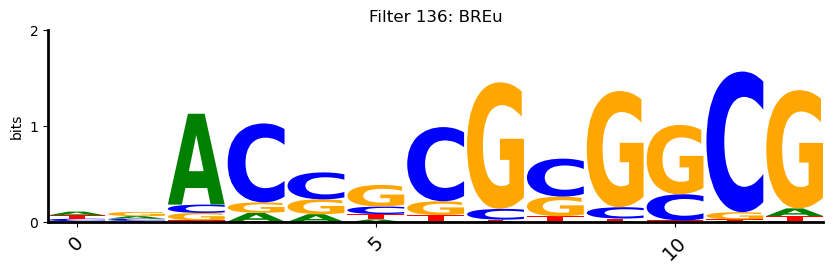

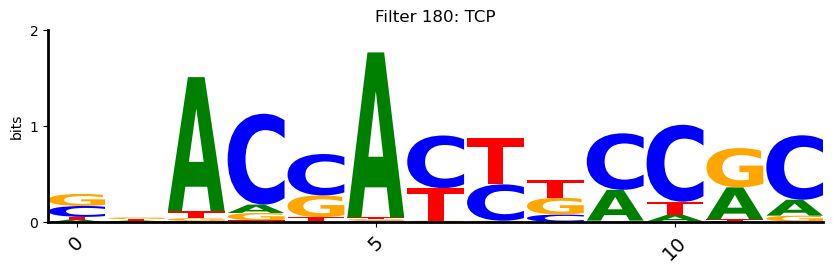

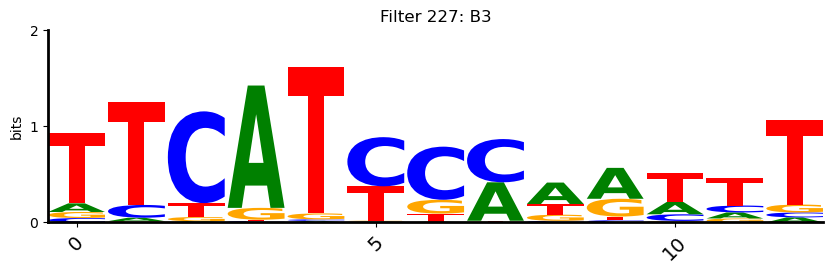

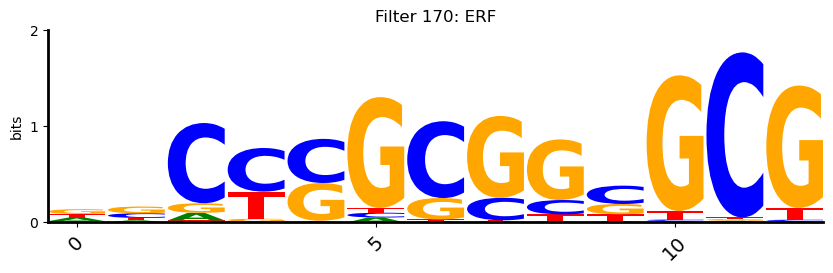

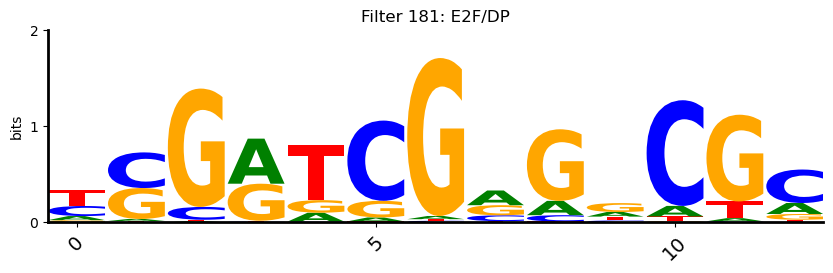

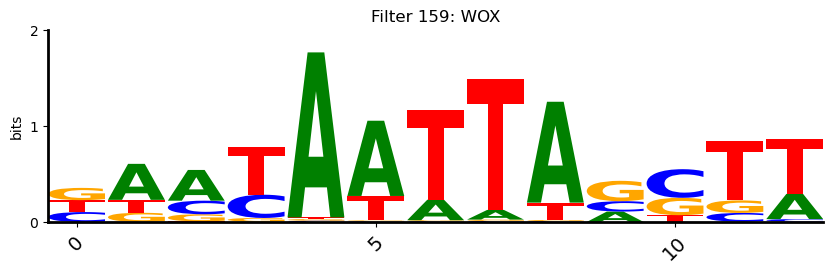

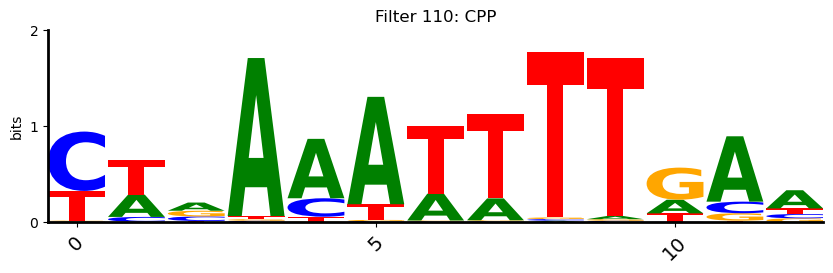

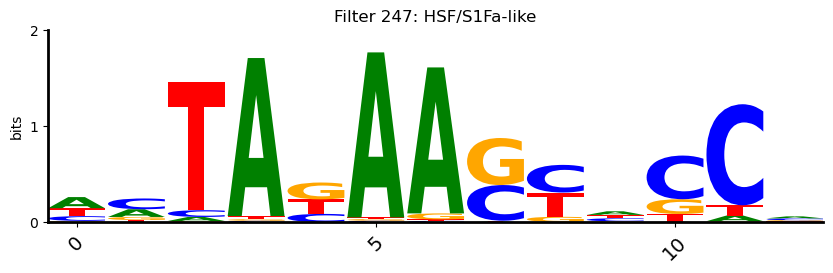

In [273]:
# Visualize a filter of choice
for i, idx in enumerate(idxs):
    pl.filter_viz(
        sdata_interpretations,
        pfms_key=pfm_key,
        filter_num=idx,
        save=os.path.join(settings.figure_dir, model, f"{model}_best_model_filter{idx}_rank{i}_viz.pdf"),
        title=f"Filter {idx}: {hit_names[i]}",
    )

# Save all the TomTom results

In [274]:
# Save as a dataframe
merged_df = pd.DataFrame()
for model in ["leaf", "proto", "combined"]:
    x = pd.read_csv(os.path.join(eu.settings.output_dir, model, f"{model}_best_model_filters_tomtom.tsv"), sep="\t", comment="#", index_col=0)
    x["system"] = model
    merged_df = pd.concat([merged_df, x])

In [275]:
merged_df = merged_df[~merged_df["Query_ID"].isna()]

In [276]:
merged_df.to_csv(os.path.join(eu.settings.output_dir, "best_models_filters_tomtom.tsv"), sep="\t", index=False)

# Loss curve

In [127]:
# Which model?
model = "combined"
trial = 5
model_type = "deepstarr"

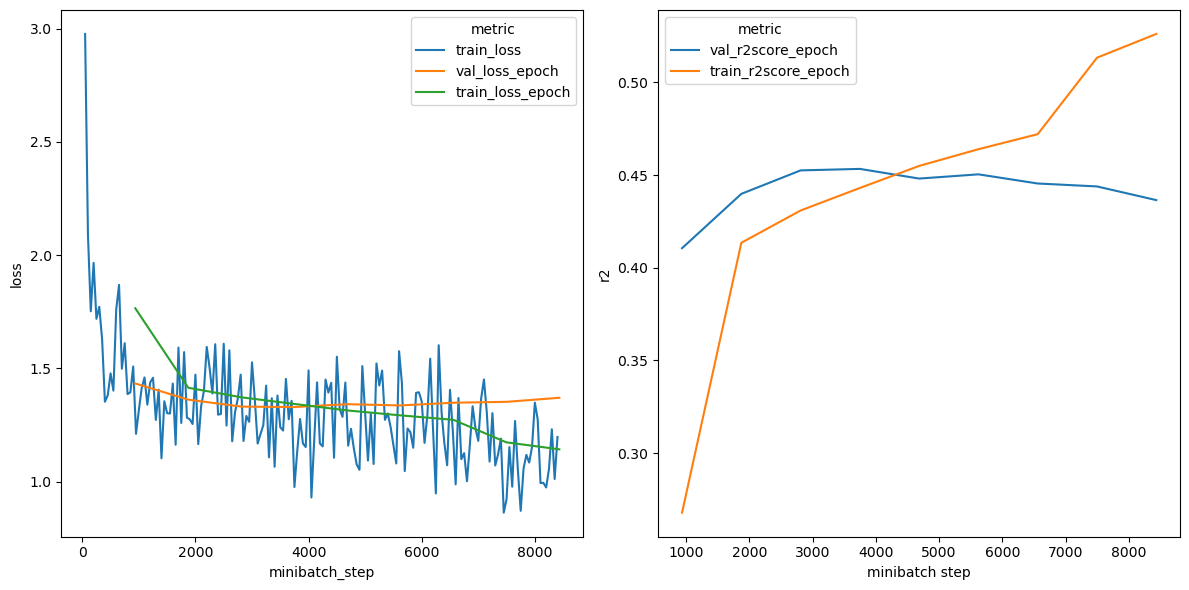

In [128]:
# Plot and save the training and metric curves
pl.training_summary(
    os.path.join(settings.logging_dir, model_type, f"{model}_trial_{trial}"),
    metric="r2",
    save=os.path.join(settings.figure_dir, model, f"{model}_best_model_training_summary.pdf")
)

# DONE!

---

# Scratch